https://techblog-history-younghunjo1.tistory.com/481

## 1. 기울기 소실 또는 폭발을 발생시키는 행렬곱(dot) 연산에서의 역전파
- RNN에서 Dot 연산에 대한 역전파 수행시 순전파 때 사용한 가중치의 전치 행렬을 반복해서 곱해주는 상황이 반복된다.
- 이 연산이 기울기 소실과 폭발을 발생시키는 과정을 살펴본다.

* norm_list:
 [2.4684068094579303, 3.335704974161037, 4.783279375373183, 6.2795873320876145, 8.080776465019055, 10.25116303229294, 12.9360635066099, 16.276861327786712, 20.454829618345983, 25.688972842084684, 32.25315718048336, 40.48895641683869, 50.824407307019094, 63.79612654485427, 80.07737014308985, 100.51298922051251, 126.16331847536827, 158.3592064825883, 198.77107967611957, 249.495615421267]


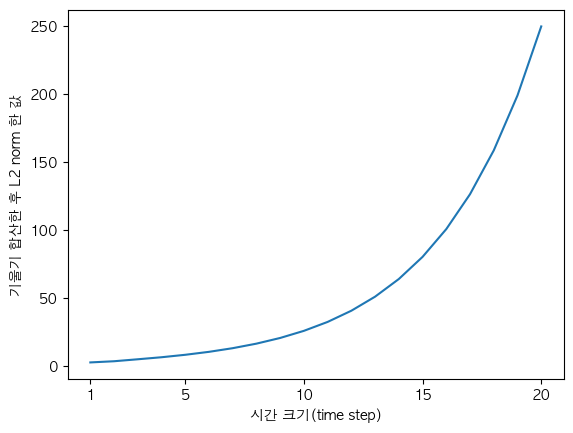

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc ('font', family= 'AppleGothic')

N = 2   # 배치 사이즈
H = 3   # 은닉 상태 벡터 차원 수
T = 20  # 시계열 길이

# h_t인 은닉상태 벡터의 기울기 값
dh = np.ones((N, H))

np.random.seed(3)

# h_t와 순전파 시 행렬 곱을 수행할 파라미터 W_h
Wh = np.random.randn(H, H)

norm_list = []

for i in range(T):
    dh = np.matmul(dh, Wh.T)
    # norm = dh
    norm = np.sqrt(np.sum(dh ** 2)) / N # 기울기 값을 하나의 스칼라 값으로 변환하기 위해 L2 취하기
    norm_list.append(norm)

print("* norm_list:\n", norm_list)
plt.plot(np.arange(len(norm_list)), norm_list) # plt.plot(x,y)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('시간 크기(time step)')
plt.ylabel('기울기 합산한 후 L2 norm 한 값')
plt.show()

- norm_list 에 dot 연산 역전파를 수행하면서 갱신되는 기울기 값이 저장되는데 이를 plot 했을 때 기울기 값이 폭발하는 형상을 확인할 수 있다.

* norm_list:
 [1.2342034047289652, 0.8339262435402592, 0.5979099219216478, 0.3924742082554759, 0.25252426453184545, 0.16017442237957719, 0.10106299614538984, 0.06358148956166684, 0.039950839098332, 0.025086887541098325, 0.015748611904532892, 0.009884999125204758, 0.006204151282595104, 0.003893806551809953, 0.002443767399386287, 0.0015337065005571367, 0.0009625497320203268, 0.0006040924319556743, 0.00037912574706291117, 0.00023793756048323344]


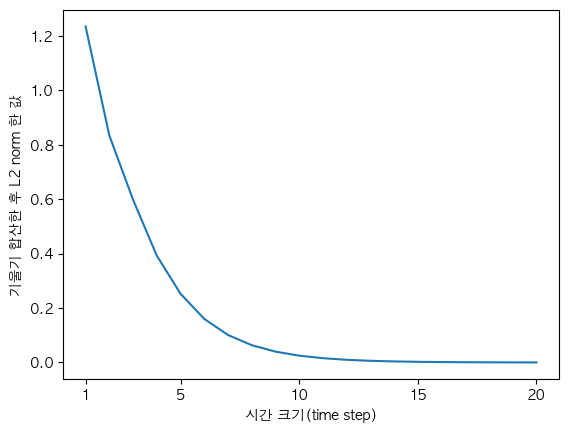

In [4]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc ('font', family= 'AppleGothic')

N = 2   # 배치 사이즈
H = 3   # 은닉 상태 벡터 차원 수
T = 20  # 시계열 길이

# h_t인 은닉상태 벡터의 기울기 값
dh = np.ones((N, H))

np.random.seed(3)

# h_t와 순전파 시 행렬 곱을 수행할 파라미터 W_h
k = 0.5  # 표준편차
Wh = np.random.randn(H, H) * k

norm_list = []

for i in range(T):
    dh = np.matmul(dh, Wh.T)
    # norm = dh
    norm = np.sqrt(np.sum(dh ** 2)) / N # 기울기 값을 하나의 스칼라 값으로 변환하기 위해 L2 취하기
    norm_list.append(norm)

print("* norm_list:\n", norm_list)
plt.plot(np.arange(len(norm_list)), norm_list) # plt.plot(x,y)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('시간 크기(time step)')
plt.ylabel('기울기 합산한 후 L2 norm 한 값')
plt.show()

# 2. 기울기 폭발에는 짤라내 대처하자, Gradient Clipping
- 기울기 폭발을 방지하는 방법인 Gradient Clipping 방식을 소스 코드로 구현해본다.

In [19]:
# 기울기 clipping src code

import numpy as np

dW1 = np.random.randn(3, 3) * 10
dW2 = np.random.randn(3, 3) * 10
grads = [dW1, dW2]

threshold = 5.0

def clip_grads(grads, threshold):
    total_norm = 0
    for grad in grads:
        total_norm = np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    # total_norm >= threshold에서 양변을 total_norm으로 나누어주기 = rate
    rate = threshold / (total_norm + 1e6)

    if rate < 1:
        for grad in grads:
            grad *= rate
    return grads
    
res = clip_grads(grads, threshold)

# 3. 기울기 소실을 방지하는 LSTM
- 기울기 소실을 방지하는 LSTM을 소스코드로 구현해본다.

In [ ]:
class LSTM:
    """ 단일 LSTM 계층 클래스 구현

    Args:
        Wx: 4개의 게이트에서 각각 입력벡터 Xt에 곱해지는 파라미터 Wx 4개
        Wh: 4개의 게이트에서 각각 이전 은닉 상태 벡터 h_t-1에 곱해지는 파라미터 Wh 4개
        b: 4개의 게이터에서 각각 더해지는 편행 b 파라미터 4개
    
    """

    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape # 이전 은닉 상태 벡터 차원 수 (batch_size, 노드수)

        # 총 4개의 게이트에서 아핀 변환을 한 번에 계산
        A = np.matmul(x, Wx) + np.matmul(h_prev. Wh) + b

        # slicing 해서 각 게이트에 보내기
        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]

        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)

        c_next = c_prev * f + g * i
        h_next = np.tanh(c_next) * o

        # 역전파 시 사용할 데이터들 캐싱해두기
        self.cache = (x, h_prev, c_prev, f, g, i, o, c_next)

        return h_next, c_next

    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, f, g, i, o, c_next = self.cache

        #====================
        # 게이트 역전파 수행
        #====================
        tanh_c_next = np.tanh(c_next)

        ds = dh_next * o * (1 - tanhc_next**2) + dc_next

        dc_prev = ds * f # 이전 기억 셀의 기울기

        # output 게이트
        do = dh_next * tanh_c_next
        do *= o * (1 - o)
        # Input 게이트
        di = ds * g
        di *= (1 - g**2)
        # Forget 게이트
        df = ds * c_prev
        df *= f * (1 - f)

        # 4개의 게이트 기울기 가로로 결합, horizontal stack
        dA = np.hstack((df, dg, di, do))

        #====================
        # affine 변환(행렬곱)에 대한 역전파 수행
        #====================
        # 파라미터 기울기 계산
        dWx = np.matmul(x.T, dA)
        dWh = np.matmul(h_prev.T, dA)
        db = dA.sum(axis=0)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        # 입력, 은닉상태 벡터 기울기 계산
        dx = np.matmul(dA, Wx.T)
        dh_prev = np.matmul(dA, Wh.T)

        return dx, dh_prev, dc_prev